In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time
!pip install torchsummary

from torchsummary import summary
from tqdm import tqdm
import tensorflow
import tensorflow as tf
from sklearn.metrics import accuracy_score
from torchvision import models
import pickle
import json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# Hyper-parameter
batch_size = 64
#  CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor(),transforms.CenterCrop(28),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_dataset = torchvision.datasets.CIFAR10(root='./', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./', train=False, transform=transform)



train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)




# preImage whitening function of tensorflow




cuda


100%|██████████| 170498071/170498071 [00:03<00:00, 48966504.70it/s]


Extracting ./cifar-10-python.tar.gz to ./


In [ ]:
class ConvModule(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ConvModule, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(True)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        return out
    

class InceptionModule(nn.Module):
    def __init__(self, in_channels, Ch1x1 , Ch3x3):
        super(InceptionModule, self).__init__()
        self.branch1 = ConvModule(in_channels, Ch1x1, kernel_size=1, stride=1, padding=0)
        self.branch2 = ConvModule(in_channels, Ch3x3, kernel_size=3, stride=1, padding=1)
    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        return torch.cat([branch1, branch2], 1)
    
class DownsampleModule(nn.Module):
    def __init__(self, in_channels, Ch3x3):
        super(DownsampleModule, self).__init__()
        self.branch1 = ConvModule(in_channels, Ch3x3, kernel_size=3, stride=2, padding=0)
        self.branch2 = nn.MaxPool2d(3, stride=2)
    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        return torch.cat([branch1, branch2], 1)

class InceptionNet(nn.Module):
    def __init__(self, classes=10):
        super(InceptionNet, self).__init__()
        self.conv1 = ConvModule(in_channels=3, out_channels=96 , kernel_size=3, stride=1, padding=0)
        self.inception1 = InceptionModule(in_channels=96, Ch1x1=32 , Ch3x3=32)
        self.inception2 = InceptionModule(in_channels=64, Ch1x1=32 , Ch3x3=48)
        self.downsample1 = DownsampleModule(in_channels=80, Ch3x3=80)
        self.inception3 = InceptionModule(in_channels=160, Ch1x1=112 , Ch3x3=48)
        self.inception4 = InceptionModule(in_channels=160, Ch1x1=96 , Ch3x3=64)
        self.inception5 = InceptionModule(in_channels=160, Ch1x1=80 , Ch3x3=80)
        self.inception6 = InceptionModule(in_channels=160, Ch1x1=48 , Ch3x3=96)
        self.downsample2 = DownsampleModule(in_channels=144, Ch3x3=96)
        self.inception7 = InceptionModule(in_channels=240, Ch1x1=176 , Ch3x3=160)
        self.inception8 = InceptionModule(in_channels=336, Ch1x1=176 , Ch3x3=160)
        self.mean_pool = nn.AdaptiveAvgPool2d((7 , 7))
        self.fc = nn.Linear(16464, classes)
    def forward(self, x):
        out = self.conv1(x)
        out = self.inception1(out)
        out = self.inception2(out)
        out = self.downsample1(out)
        out = self.inception3(out)
        out = self.inception4(out)
        out = self.inception5(out)
        out = self.inception6(out)
        out = self.downsample2(out)
        out = self.inception7(out)
        out = self.inception8(out)
        out = self.mean_pool(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [ ]:


class MLP1x512(nn.Module):
    def __init__(self, num_classes=10):
        super(MLP1x512, self).__init__()
        self.fc1 = nn.Linear(28 * 28 * 3, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
    
# summary(MLP1x512().to(device),(3,28,28))

In [ ]:

class Conv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(Conv, self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,stride=stride, padding=padding)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.lrn = nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2)

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.lrn(x)
        return x

class AlexNetSmall(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNetSmall, self).__init__()
        self.conv1 = Conv(in_channels=3, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.conv2 = Conv(in_channels=64, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.fc1 = nn.Linear(64 * 6 * 6, 384)
        self.fc2 = nn.Linear(384, 192)
        self.fc3 = nn.Linear(192, num_classes)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x
    

model = AlexNetSmall().to(device)
summary(model,(3,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]           4,864
              ReLU-2           [-1, 64, 28, 28]               0
         MaxPool2d-3           [-1, 64, 13, 13]               0
 LocalResponseNorm-4           [-1, 64, 13, 13]               0
              Conv-5           [-1, 64, 13, 13]               0
            Conv2d-6           [-1, 64, 13, 13]         102,464
              ReLU-7           [-1, 64, 13, 13]               0
         MaxPool2d-8             [-1, 64, 6, 6]               0
 LocalResponseNorm-9             [-1, 64, 6, 6]               0
             Conv-10             [-1, 64, 6, 6]               0
           Linear-11                  [-1, 384]         885,120
             ReLU-12                  [-1, 384]               0
           Linear-13                  [-1, 192]          73,920
             ReLU-14                  [

In [ ]:
def LabelCorruption(percentage,myloader):
    labels = myloader.dataset.targets[:]
    data = myloader.dataset.data
#     print(data.shape)
    num = int(len(labels)*percentage)
    idxes = []
    # generate unique random index
    while len(idxes) < num:
        idx = np.random.randint(0,len(labels))
        if idx not in idxes:
            idxes.append(idx)
    # change the label of the index
    for idx in idxes:
        randomLabel = np.random.randint(0,10)
        while randomLabel == labels[idx]:
            randomLabel = np.random.randint(0,10)
        labels[idx] = randomLabel
    
    corrupted_dataset = torchvision.datasets.CIFAR10(root='./', train=True, download=True, transform=transform)
    corrupted_dataset.data = data
    corrupted_dataset.targets = labels
    corrupted_loader = torch.utils.data.DataLoader(dataset=corrupted_dataset, batch_size=batch_size, shuffle=True)
    return corrupted_loader




In [ ]:
def trainmodel(epochs=10,train_loader=train_loader,lr=0.001,corruption=0, modelName="Alexnet"):
    model = None
    if modelName == "Alexnet":
        model = AlexNetSmall()
    elif modelName == "Inception":
        model = InceptionNet()
    elif modelName == "MLP":
        model = MLP1x512()

    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    train_loss = []
    train_acc = []
    if corruption>0:
        train_loader = LabelCorruption(percentage=corruption,myloader=train_loader)
    time1 = time.time()
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        running_acc = 0.0
        for i, (images, labels) in enumerate(tqdm(train_loader)):
            images = images.to(device)
            labels = labels.to(device)
            # Forward pass
#             print(images.size())
            outputs = model(images)
            loss = criterion(outputs, labels)
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Compute accuracy
            _, argmax = torch.max(outputs, 1)
            accuracy = (labels == argmax.squeeze()).float().mean()
            running_acc += accuracy / len(train_loader)
            running_loss += loss / len(train_loader)
        train_loss.append(float(running_loss))
        train_acc.append(float(running_acc))
        # print("Epoch:" , epoch , "Train Loss" , running_loss , "Test Loss" , test_loss , "Train Accuracy" , running_acc , "Test Accuracy" , test_acc)
    time2 = time.time()
    timetaken = time2-time1
    return train_loss, train_acc , model,timetaken


In [ ]:

modelNames = ["Alexnet","Inception","MLP"]
modelDict = {}
for modelName in modelNames:
    percentage = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
    perTrainlosslst = []
    perTrainacclst = []
    pertimetakenlst = []
    permodellst = []
    lr = 0.001
    if modelName == "Inception":
        lr = 0.1
    for i in percentage:
        perTrainloss, perTrainacc , permodel,pertimetaken = trainmodel(epochs=10,train_loader=train_loader,lr=0.001,corruption=i,modelName=modelName)
        perTrainlosslst.append(perTrainloss)
        perTrainacclst.append(perTrainacc)
        pertimetakenlst.append(pertimetaken)
        permodellst.append(permodel)
        print("Model " , modelName , "Percentage of corruption: ",i,"Time taken: ",pertimetaken , "Train Accuracy: ",perTrainacc[-1] , "Train Loss: ",perTrainloss[-1])
    # finallst = [perTrainlosslst,perTrainacclst,pertimetakenlst,permodellst]
    # modelDict[modelName] = finallst
    finaldict = {
        "TrainLosslst":perTrainlosslst,
        "TrainAccuracylst":perTrainacclst,
        "TimeTakenlst":pertimetakenlst,
        "Modellst":permodellst
    }
    modelDict[modelName] = finaldict








Files already downloaded and verified


100%|██████████| 782/782 [00:20<00:00, 38.58it/s]


Model  Alexnet Percentage of corruption:  0.1 Time taken:  215.57692289352417 Train Accuracy:  0.4713069498538971 Train Loss:  1.5727667808532715
Files already downloaded and verified


100%|██████████| 782/782 [00:21<00:00, 36.50it/s]


Model  Alexnet Percentage of corruption:  0.2 Time taken:  209.2530379295349 Train Accuracy:  0.40345239639282227 Train Loss:  1.7959039211273193
Files already downloaded and verified


100%|██████████| 782/782 [00:21<00:00, 36.68it/s]


Model  Alexnet Percentage of corruption:  0.3 Time taken:  208.96322655677795 Train Accuracy:  0.3373161256313324 Train Loss:  1.967991828918457
Files already downloaded and verified


100%|██████████| 782/782 [00:21<00:00, 37.14it/s]


Model  Alexnet Percentage of corruption:  0.4 Time taken:  213.20202493667603 Train Accuracy:  0.2736571133136749 Train Loss:  2.100090980529785
Files already downloaded and verified


100%|██████████| 782/782 [00:21<00:00, 35.93it/s]


Model  Alexnet Percentage of corruption:  0.5 Time taken:  217.47523474693298 Train Accuracy:  0.22898007929325104 Train Loss:  2.184000015258789
Files already downloaded and verified


100%|██████████| 782/782 [00:21<00:00, 36.74it/s]


Model  Alexnet Percentage of corruption:  0.6 Time taken:  213.5008361339569 Train Accuracy:  0.1800072342157364 Train Loss:  2.2496557235717773
Files already downloaded and verified


100%|██████████| 782/782 [00:21<00:00, 36.14it/s]


Model  Alexnet Percentage of corruption:  0.7 Time taken:  215.37031054496765 Train Accuracy:  0.1447010189294815 Train Loss:  2.2870700359344482
Files already downloaded and verified


100%|██████████| 782/782 [00:22<00:00, 35.46it/s]


Model  Alexnet Percentage of corruption:  0.8 Time taken:  213.71356558799744 Train Accuracy:  0.1131313294172287 Train Loss:  2.3012402057647705
Files already downloaded and verified


100%|██████████| 782/782 [00:21<00:00, 35.84it/s]


Model  Alexnet Percentage of corruption:  0.9 Time taken:  215.4880542755127 Train Accuracy:  0.10553853958845139 Train Loss:  2.302250862121582
Files already downloaded and verified


100%|██████████| 782/782 [00:21<00:00, 35.67it/s]


Model  Alexnet Percentage of corruption:  1.0 Time taken:  215.23339319229126 Train Accuracy:  0.10945473611354828 Train Loss:  2.300926923751831
Files already downloaded and verified


100%|██████████| 782/782 [00:26<00:00, 29.82it/s]


Model  Inception Percentage of corruption:  0.1 Time taken:  267.5152018070221 Train Accuracy:  0.9416963458061218 Train Loss:  0.19799284636974335
Files already downloaded and verified


100%|██████████| 782/782 [00:27<00:00, 28.84it/s]


Model  Inception Percentage of corruption:  0.2 Time taken:  271.01886010169983 Train Accuracy:  0.8677866458892822 Train Loss:  0.4219377338886261
Files already downloaded and verified


100%|██████████| 782/782 [00:26<00:00, 30.04it/s]


Model  Inception Percentage of corruption:  0.3 Time taken:  265.0254943370819 Train Accuracy:  0.7080397009849548 Train Loss:  0.9047900438308716
Files already downloaded and verified


100%|██████████| 782/782 [00:27<00:00, 28.40it/s]


Model  Inception Percentage of corruption:  0.4 Time taken:  270.14671206474304 Train Accuracy:  0.6058177947998047 Train Loss:  1.1937824487686157
Files already downloaded and verified


100%|██████████| 782/782 [00:26<00:00, 29.62it/s]


Model  Inception Percentage of corruption:  0.5 Time taken:  270.9144825935364 Train Accuracy:  0.49766215682029724 Train Loss:  1.5035456418991089
Files already downloaded and verified


100%|██████████| 782/782 [00:27<00:00, 28.20it/s]


Model  Inception Percentage of corruption:  0.6 Time taken:  271.9815435409546 Train Accuracy:  0.4139825105667114 Train Loss:  1.7165552377700806
Files already downloaded and verified


100%|██████████| 782/782 [00:27<00:00, 28.89it/s]


Model  Inception Percentage of corruption:  0.7 Time taken:  272.47603821754456 Train Accuracy:  0.31651607155799866 Train Loss:  1.95168137550354
Files already downloaded and verified


100%|██████████| 782/782 [00:27<00:00, 28.43it/s]


Model  Inception Percentage of corruption:  0.8 Time taken:  273.56708312034607 Train Accuracy:  0.28576552867889404 Train Loss:  2.012470006942749
Files already downloaded and verified


100%|██████████| 782/782 [00:27<00:00, 28.87it/s]


Model  Inception Percentage of corruption:  0.9 Time taken:  272.8572497367859 Train Accuracy:  0.26684364676475525 Train Loss:  2.057488203048706
Files already downloaded and verified


100%|██████████| 782/782 [00:27<00:00, 27.96it/s]


Model  Inception Percentage of corruption:  1.0 Time taken:  276.01704239845276 Train Accuracy:  0.31941303610801697 Train Loss:  1.9238299131393433
Files already downloaded and verified


100%|██████████| 782/782 [00:20<00:00, 37.84it/s]


Model  MLP Percentage of corruption:  0.1 Time taken:  210.4724988937378 Train Accuracy:  0.4832756519317627 Train Loss:  1.579699158668518
Files already downloaded and verified


100%|██████████| 782/782 [00:20<00:00, 38.03it/s]


Model  MLP Percentage of corruption:  0.2 Time taken:  209.94660091400146 Train Accuracy:  0.43318384885787964 Train Loss:  1.7575852870941162
Files already downloaded and verified


100%|██████████| 782/782 [00:20<00:00, 37.80it/s]


Model  MLP Percentage of corruption:  0.3 Time taken:  209.56355094909668 Train Accuracy:  0.38299185037612915 Train Loss:  1.89108145236969
Files already downloaded and verified


100%|██████████| 782/782 [00:20<00:00, 37.57it/s]


Model  MLP Percentage of corruption:  0.4 Time taken:  209.98135089874268 Train Accuracy:  0.33106204867362976 Train Loss:  2.0114245414733887
Files already downloaded and verified


100%|██████████| 782/782 [00:21<00:00, 36.46it/s]


Model  MLP Percentage of corruption:  0.5 Time taken:  210.17259097099304 Train Accuracy:  0.2866046726703644 Train Loss:  2.1000757217407227
Files already downloaded and verified


100%|██████████| 782/782 [00:20<00:00, 37.67it/s]


Model  MLP Percentage of corruption:  0.6 Time taken:  210.8296308517456 Train Accuracy:  0.2418278306722641 Train Loss:  2.170321464538574
Files already downloaded and verified


100%|██████████| 782/782 [00:21<00:00, 36.17it/s]


Model  MLP Percentage of corruption:  0.7 Time taken:  211.66167187690735 Train Accuracy:  0.1988891065120697 Train Loss:  2.2200441360473633
Files already downloaded and verified


100%|██████████| 782/782 [00:21<00:00, 36.60it/s]


Model  MLP Percentage of corruption:  0.8 Time taken:  208.4828646183014 Train Accuracy:  0.175591379404068 Train Loss:  2.2504076957702637
Files already downloaded and verified


100%|██████████| 782/782 [00:20<00:00, 38.43it/s]


Model  MLP Percentage of corruption:  0.9 Time taken:  205.30698442459106 Train Accuracy:  0.1655810922384262 Train Loss:  2.261382579803467
Files already downloaded and verified


100%|██████████| 782/782 [00:21<00:00, 36.54it/s]


Model  MLP Percentage of corruption:  1.0 Time taken:  207.37277126312256 Train Accuracy:  0.16825847327709198 Train Loss:  2.249277353286743


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# save time taken for each model in a file
import json
timetakenjson = {}
trainlossjson = {}
modellst = {}
path = "/content/drive/MyDrive/Untitled Folder"
for modelName in modelNames:
    timetakenjson[modelName] = modelDict[modelName]["TimeTakenlst"]


for modelName in modelNames:
    trainlossjson[modelName] = modelDict[modelName]["TrainLosslst"]


with open(path + "timetaken.json", 'w') as f:
    json.dump(timetakenjson, f)

with open(path + "trainloss.json", 'w') as f:
    json.dump(trainlossjson, f)


In [2]:
path = "/content/drive/MyDrive/Untitled Folder/"


In [ ]:
#
for modelName in modelNames:
    for i in range(len(modelDict[modelName]["Modellst"])):
        # state_dict()
        torch.save(modelDict[modelName]["Modellst"][i].state_dict(), path + modelName + str(i) + ".pt")



In [ ]:
#loading model 
modellst= {}
modelNames = ["Alexnet","Inception","MLP"]
path = "/content/drive/MyDrive/Untitled Folder"



for modelName in modelNames:
    modellst[modelName] = []
    for i in range((10)):
        model_state_dict = torch.load(path + modelName + str(i) + ".pt")
        modelobj = None
        if modelName == "Alexnet":
            modelobj = AlexNetSmall()
        elif modelName == "Inception":
            modelobj = InceptionNet()
        elif modelName == "MLP":
            modelobj = MLP1x512()
        modelobj.load_state_dict(model_state_dict)
        modellst[modelName].append(modelobj)

In [ ]:
def testlossget(modelDict,test_loader):
    modelNames = modelDict.keys()
    # all image test loss
    testlosslst = {
                   "MLP":[0] * 10,
                   "Alexnet":[0] * 10,
                   "Inception":[0] * 10
                   }
    for i,(images,labels) in enumerate(tqdm(test_loader)):
        images = images.to(device)
        labels = labels.to(device)

        for modelName in modelNames:
            models = modelDict[modelName]
            criterion = nn.CrossEntropyLoss()
            t = 0

            for model in models:
                model.eval()
                model.cuda()
                test_loss = testlosslst[modelName][t]
                outputs = model(images)
                loss = criterion(outputs, labels)
                _, argmax = torch.max(outputs, 1)
                test_loss += loss / len(test_loader)
                testlosslst[modelName][t] = float(test_loss)
                t += 1

    return testlosslst

testlosslst = testlossget(modellst,test_loader)

with open(path + 'testloss.json', 'w') as fp:
    json.dump(testlosslst, fp)

In [25]:
timetakenjson =  json.load(open(path + "timetaken.json", 'r'))
testlossjson =  json.load(open(path + "testloss.json", 'r'))

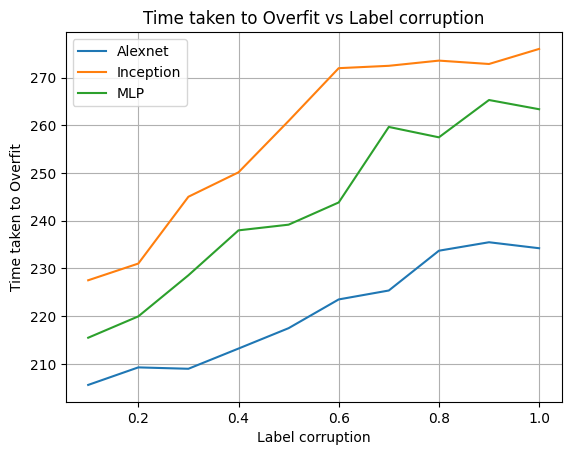

In [29]:
percentage = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

def plotTimegraph(modelDict):
    modelNames = modelDict.keys()
    i = 0
    for modelName in modelNames:
        timetakenlst = modelDict[modelName]
        plt.plot(percentage,timetakenlst[1:] , label = modelName)
    plt.xlabel("Label corruption")
    plt.ylabel("Time taken to Overfit")
    plt.title("Time taken to Overfit vs Label corruption")
    plt.legend()
    plt.grid()
plotTimegraph(timetakenjson)


    

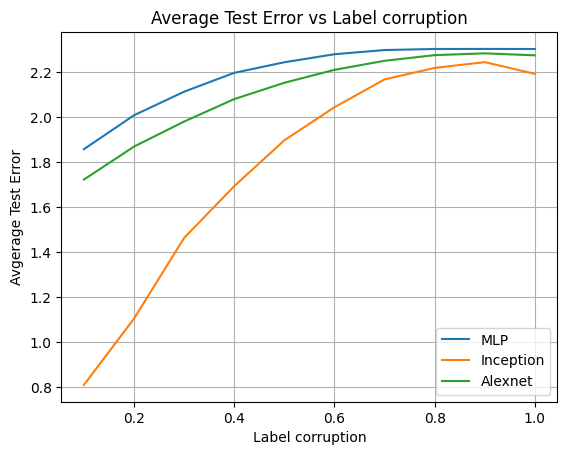

In [28]:
percentage = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

def plotAvgTestgraph(modelDict):
    modelNames = modelDict.keys()
    i = 0
    for modelName in modelNames:
        avgTestloss = modelDict[modelName]
        plt.plot(percentage,avgTestloss , label = modelName)
    plt.xlabel("Label corruption")
    plt.ylabel("Avgerage Test Error")
    plt.title("Average Test Error vs Label corruption")
    plt.legend()
    plt.grid()
plotAvgTestgraph(testlossjson)
